In [45]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import optuna
import seaborn as sns
import joblib
from matplotlib.ticker import FuncFormatter
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from data.shots_data_retriever import ShotsDataRetriever

In [47]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

In [48]:
print(df.groupby('is_goal').size())
df

is_goal
0    265840
1     28669
dtype: int64


,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,...,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed,time_since_powerplay,away_skaters,home_skaters
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,...,61,11,1,17.088007,False,0.000000,17.088007,0,5,5
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,...,54,-5,5,36.715120,False,0.000000,7.343024,0,5,5
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,...,72,0,18,62.008064,False,0.000000,3.444892,0,5,5
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,...,77,-2,19,45.880279,False,0.000000,2.414752,0,5,5
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,...,47,34,16,14.317821,False,0.000000,0.894864,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68060,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,...,72,-21,21,5.385165,False,0.000000,0.256436,0,5,5
68061,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,...,95,-17,16,58.189346,False,0.000000,3.636834,0,5,5
68062,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,...,76,38,2,28.160256,True,27.501452,14.080128,0,5,5
68063,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,...,60,40,32,51.478151,False,0.000000,1.608692,0,6,5


In [49]:
cv_folds = 3

### XGBClassifier v0:
- Trained on `angle_to_goal` and `distance`
- No hyperparameter tuning

In [50]:
X0 = df[['angle_to_goal', 'distance']]
y = df['is_goal']

X_train_0, X_val_0, y_train, y_val = train_test_split(X0, y, test_size=0.3, random_state=1)


In [ ]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-not_tuned",
    config={
        "model": "XGBClassifier",
    }
)

model_path = "xgboost_v0_model.pkl"

xgboost_v0 = XGBClassifier()
xgboost_v0.fit(X_train_0, y_train)

joblib.dump(xgboost_v0, model_path)
artifact = wandb.Artifact(
    name="xgboost_v0_model",
    type="model",
    description="XGBoost classifier for NHL goal prediction (version 0) - not tuned",
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

y_pred = xgboost_v0.predict(X_val_0)
y_pred_prob = xgboost_v0.predict_proba(X_val_0)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})

results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.log({"results-not_tuned": wandb.Table(dataframe=results_v0)})

wandb.finish()
os.remove(model_path)

accuracy,▁
roc_auc,▁
accuracy,0.90126
roc_auc,0.71096


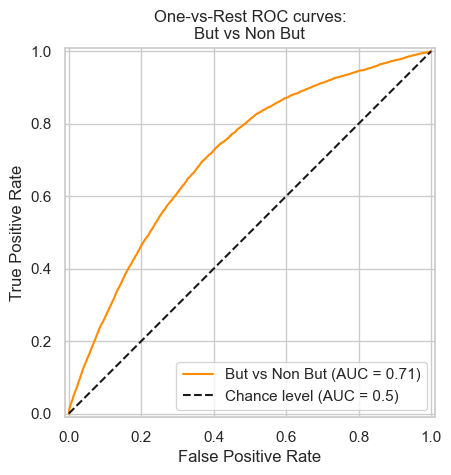

In [ ]:
display = RocCurveDisplay.from_predictions(
    results_v0['is_goal'],
    results_v0['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="XGBClassifier v0\nOne-vs-Rest ROC curves:\nBut vs Non But",
)

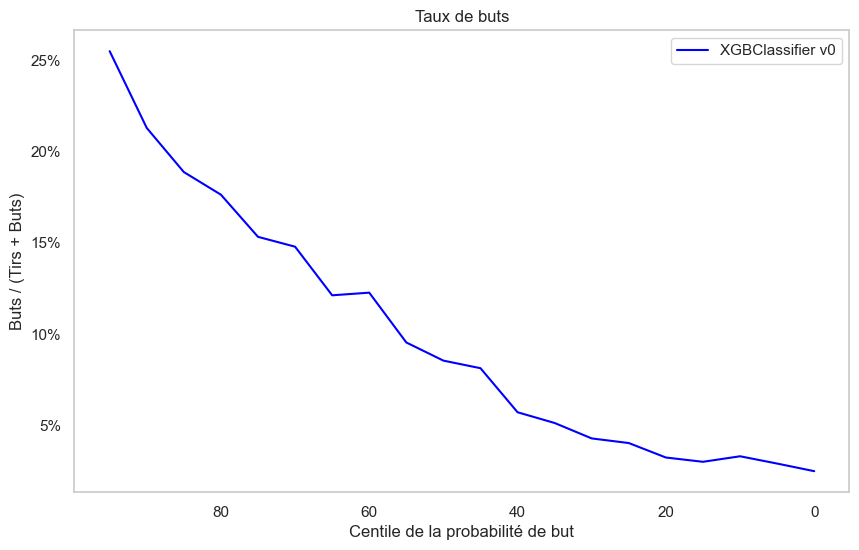

In [ ]:
gr_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

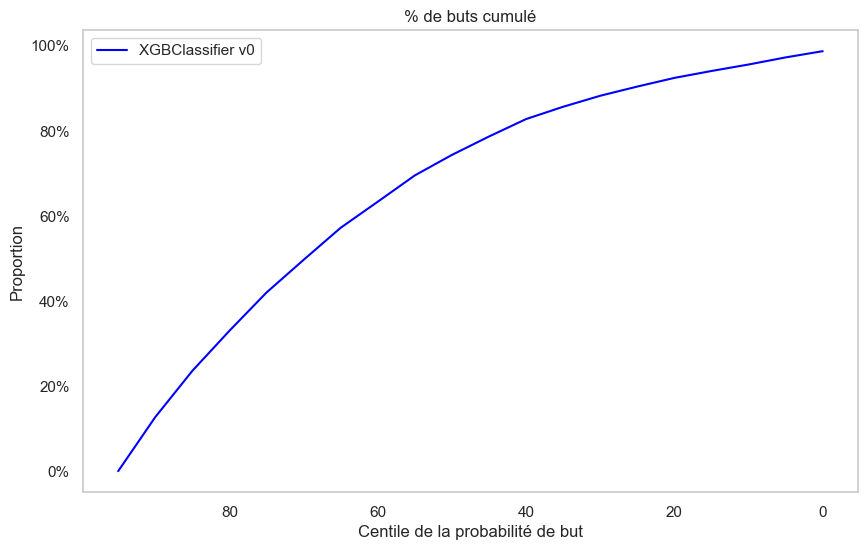

In [54]:
cg_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

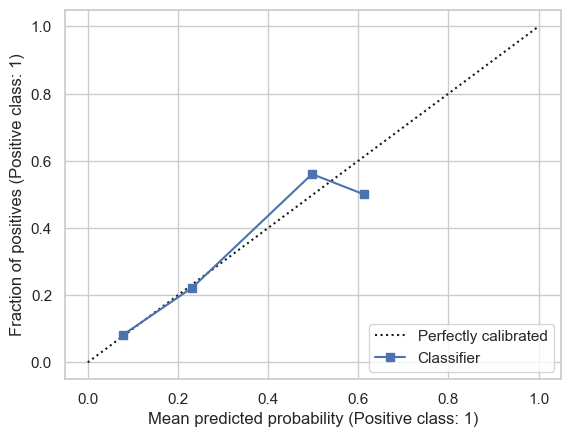

In [55]:
disp = CalibrationDisplay.from_predictions(y_val, results_v0['goal_proba'])
plt.show()

### XGBClassifier v1:
- Trained on all features
- Hyperparameters optimized

In [56]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X1 = df1.drop(columns=['is_goal'])
y = df1['is_goal']

X_train_1, X_val_1, y_train, y_val = train_test_split(X1, y, test_size=0.3, random_state=1)

#### Scoring metric

There is a notable class imbalance in the dataset - 276763 class 0 data points for 29006 class 1 data points. Further - we are not interested in the classifier's ability to correctly label a shot as a goal or not. Instead, we are more focused on creating a classifier able to predict a realistic probability of goal. Given these requirements, I will choose **log-loss** as my scoring metric.

#### Hyperparameter optimization method
I do not have much experience optimizing XGBoost models and so do not have an intuition for which hyperparameter values to explore. Thus, I will **Bayesian Optimization** as it is capable of intelligently exploring different hyperparameter values without requiring them to be set ahead of time.

In [ ]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-tuned",
    config={
        "cv_folds": cv_folds,
        "eval_metric": "logloss",
        "model": "XGBClassifier",
    },
    reinit=True
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBClassifier(**params, eval_metric='logloss')
    
    score = cross_val_score(model, X_train_1, y_train, scoring='neg_log_loss', cv=cv_folds).mean()
    
    wandb.log({
        "trial_number": trial.number,
        "n_estimators": params['n_estimators'],
        "max_depth": params['max_depth'],
        "learning_rate": params['learning_rate'],
        "colsample_bytree": params['colsample_bytree'],
        "subsample": params['subsample'],
        "min_child_weight": params['min_child_weight'],
        "neg_log_loss": score
    })
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

wandb.config.update(study.best_params)

xgboost_v1 = XGBClassifier(**study.best_params, eval_metric='logloss')
xgboost_v1.fit(X_train_1, y_train)

model_path = "xgboost_v1_model.pkl"
joblib.dump(xgboost_v1, model_path)
artifact = wandb.Artifact(
    name="xgboost_v0_model",
    type="model",
    description="XGBoost classifier for NHL goal prediction (version 0) - not tuned",
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

y_pred = xgboost_v1.predict(X_val_1)
y_pred_prob = xgboost_v1.predict_proba(X_val_1)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})
print(f"Accuracy: {accuracy}", f"ROC AUC: {roc_auc}")

results_v1 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results-tuned": wandb.Table(dataframe=results_v1)})

print("Best parameters:", study.best_params)

wandb.finish()
os.remove(model_path)

[I 2024-11-20 14:23:14,286] A new study created in memory with name: no-name-2c02099d-1ea5-44b2-9d46-31982fb91bb9
[I 2024-11-20 14:23:29,152] Trial 0 finished with value: -0.26886146450509707 and parameters: {'n_estimators': 65, 'max_depth': 7, 'learning_rate': 0.25990601116332424, 'colsample_bytree': 0.7373191397524638, 'subsample': 0.9335610559664973, 'min_child_weight': 1}. Best is trial 0 with value: -0.26886146450509707.
[I 2024-11-20 14:24:52,449] Trial 1 finished with value: -0.29095780683446937 and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.13290153798496485, 'colsample_bytree': 0.6086142502890342, 'subsample': 0.5780600373761047, 'min_child_weight': 3}. Best is trial 0 with value: -0.26886146450509707.
[I 2024-11-20 14:25:44,336] Trial 2 finished with value: -0.2696054152655494 and parameters: {'n_estimators': 429, 'max_depth': 5, 'learning_rate': 0.12976863746717335, 'colsample_bytree': 0.8085682469108127, 'subsample': 0.7615362754817114, 'min_child_

Accuracy: 0.9063868799022105 ROC AUC: 0.7782492599606768
Best parameters: {'n_estimators': 141, 'max_depth': 6, 'learning_rate': 0.08340663021471245, 'colsample_bytree': 0.9277330268936956, 'subsample': 0.9036643906889194, 'min_child_weight': 7}


accuracy,▁
colsample_bytree,▄▂▅▅▂▄▃▅▅▁██▇▇▇▆▇▇▆▇▆▆▆▅▆▇▆▄▆▅▇▅▆█▇▆▇▅▆▂
learning_rate,▇▄▄▅▃▅▅▂▅▁▃▂▃▁▂▆▄▃▃▂▃▂▁▃█▄▃▄▅▄▂▆▄▂▃▄▅▃▂▁
max_depth,▅▇█▂▂▃▆▂▁▅▄▅▆▄▅▃▃▃▄▁▄▃▂▆▅▃▄▅▃▂▇█▂▃▃▃▄▅▄▄
min_child_weight,▁▃▇▇▆▆▅▅▅▆▃▁▃▂▂▄▄▄▃▂█▆▆▁▆▆▅▃▆▇█▆▅▄▄▃▆▆▆▆
n_estimators,▁▇▇▇▃▅▅▅▃▁▃▂▂▂▄▄▂▂▂▃▃▃▂▄▃▂▂▁█▂▁▄▃▄▂▃▁▂▂▄
neg_log_loss,▇▄██▆██▁██████▄████▇▇█▇▅███▅██▄▇████████
roc_auc,▁
subsample,▇▂▅█▄█▄▁▃▆▃▃▂▂▅▆▇▇▅▇▄▄▆▅▄▇▆▇▅▆▇▂▅▃▇▆█▇▆█
trial_number,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90639


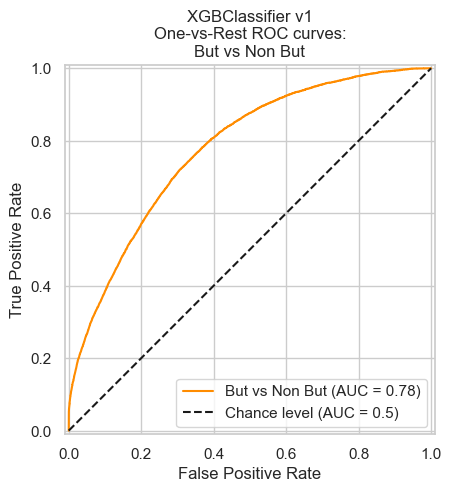

In [58]:
display = RocCurveDisplay.from_predictions(
    results_v1['is_goal'],
    results_v1['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="XGBClassifier v1\nOne-vs-Rest ROC curves:\nBut vs Non But",
)

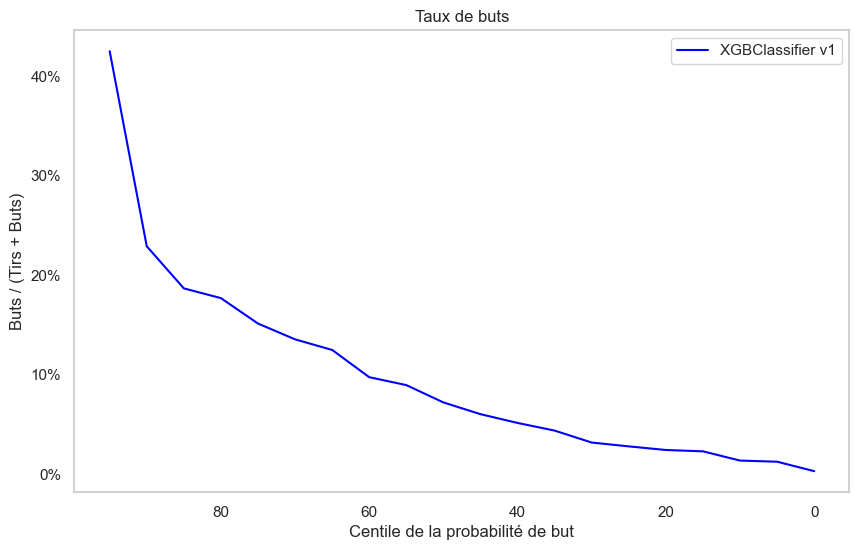

In [59]:
gr_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

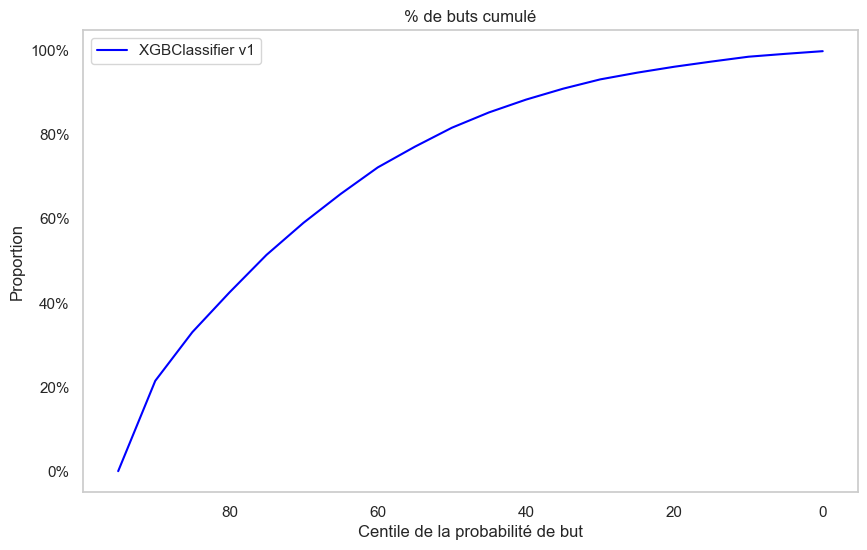

In [60]:
cg_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

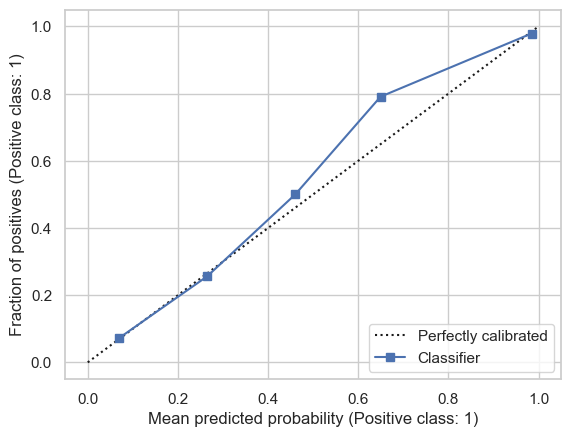

In [61]:
disp = CalibrationDisplay.from_predictions(y_val, results_v1['goal_proba'])
plt.show()

### XGBClassifier v2:
- Numeric data scaled
- Trained on select features
- Hyperparameters tuned

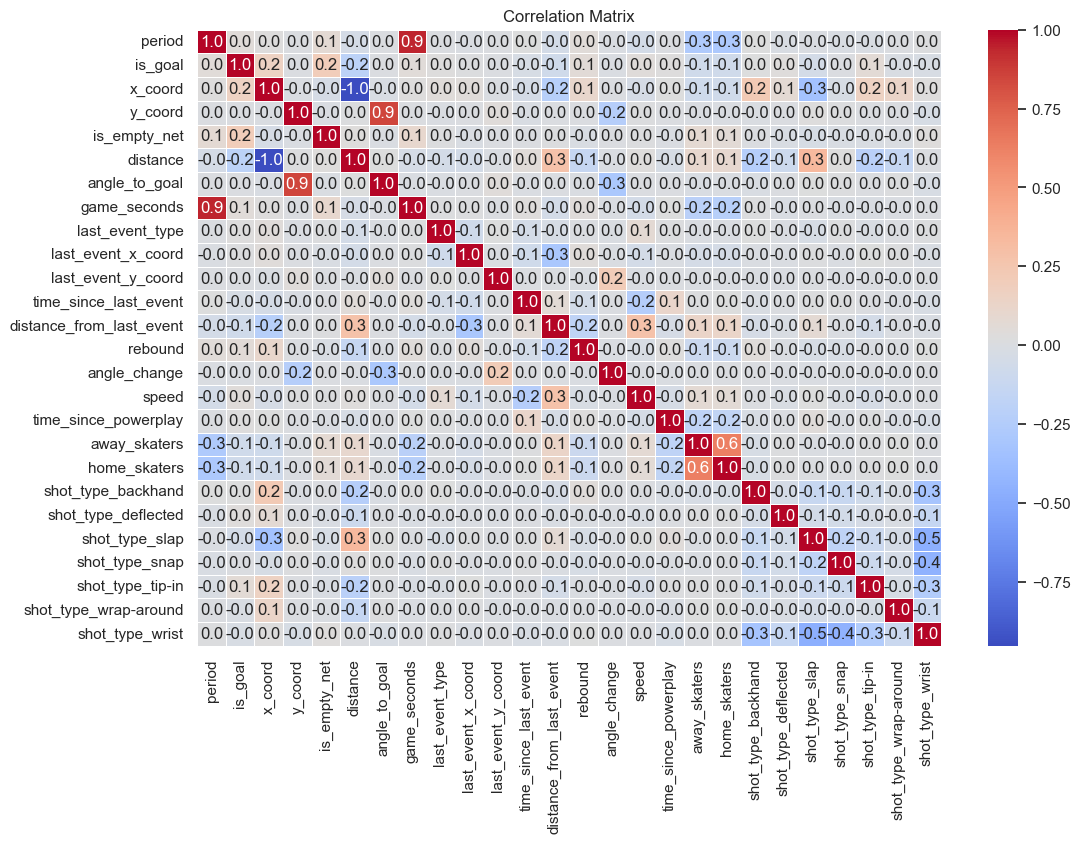

In [62]:
corr_matrix = df1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Sklearn
Created a feature engineering pipeline that scales numeric values and selects k-best features.

Created an overall pipeline that goes through the feature engineering pipeline and then fits the optimized xgboost model with the new data.

In [ ]:
wandb.init(project="IFT6758.2024-A02", name="xgboost-featured_engineered_and_tuned")

wandb.config = {
    "model": "XGBClassifier",
    "scoring_metric": "roc_auc",
    "cv_folds": cv_folds,
    "feature_selection": "mutual_info_classif",
    "classifier_params": study.best_params
}

numeric_features = [
    'period', 'x_coord', 'y_coord', 'is_empty_net', 'distance', 
    'angle_to_goal', 'game_seconds', 'last_event_x_coord', 
    'last_event_y_coord', 'time_since_last_event', 
    'distance_from_last_event', 'rebound', 'angle_change', 'speed'
]

boolean_features = [col for col in X_train_1.columns if col.startswith('shot_type_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bool', 'passthrough', boolean_features)
    ]
)

feature_engineering_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all'))
])

pipeline = Pipeline([
    ('feature_engineering', feature_engineering_pipeline),
    ('classifier', xgboost_v1)
])

pipeline.fit(X_train_1, y_train)

y_pred = pipeline.predict(X_val_1)
y_pred_prob = pipeline.predict_proba(X_val_1)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc
})

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final Model ROC AUC: {roc_auc:.4f}")

results_v2 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.log({"results-featured_engineered_and_tuned": wandb.Table(dataframe=results_v2)})

xgboost_v2 = pipeline.named_steps['classifier']

model_path = "xgboost_v2_model.pkl"
joblib.dump(xgboost_v0, model_path)
artifact = wandb.Artifact(
    name="xgboost_v0_model",
    type="model",
    description="XGBoost classifier for NHL goal prediction (version 0) - not tuned",
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()
os.remove(model_path)

Final Model Accuracy: 0.9065
Final Model ROC AUC: 0.7746


accuracy,▁
roc_auc,▁
accuracy,0.9065
roc_auc,0.77461


C:\Users\Dell.DESKTOP-4AU2O53\AppData\Local\Temp\ipykernel_11272\941796982.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


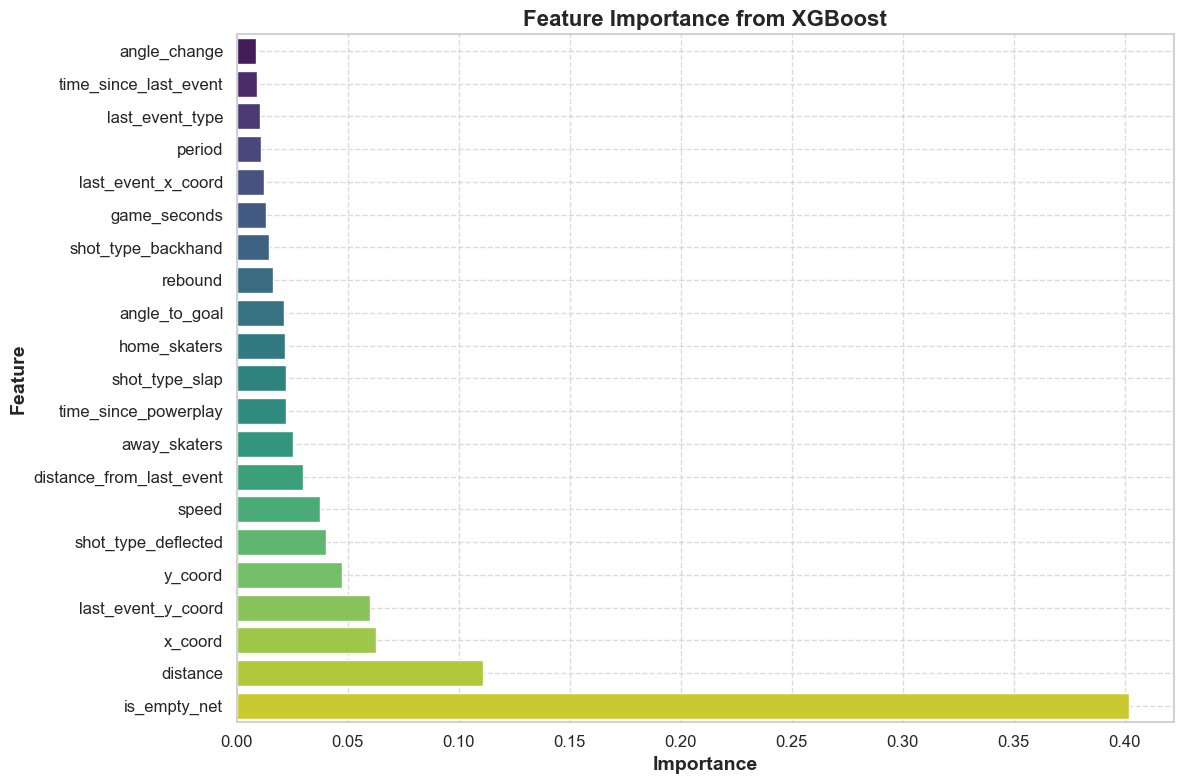

In [ ]:
sns.set_theme(style="whitegrid")

importances = xgboost_v2.feature_importances_

selected_features = pipeline.named_steps['feature_engineering'].named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = [X_train_1.columns[i] for i in selected_features]

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': importances[selected_features]
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x="importance", 
    y="feature", 
    data=feature_importance_df, 
    palette="viridis",
    orient="h"
)

ax.set_xlabel('Importance', fontsize=14, weight='bold')
ax.set_ylabel('Feature', fontsize=14, weight='bold')
ax.set_title('Feature Importance from XGBoost', fontsize=16, weight='bold')

ax.tick_params(axis='both', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

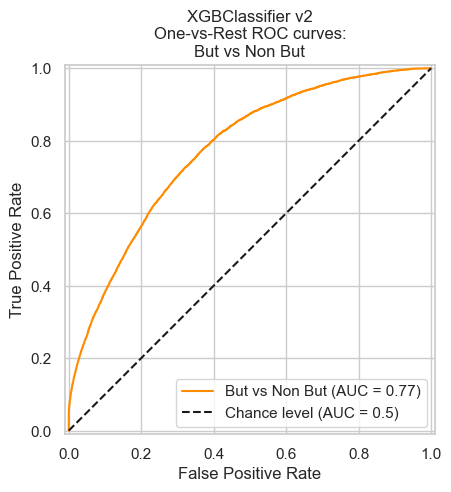

In [72]:
display = RocCurveDisplay.from_predictions(
    results_v2['is_goal'],
    results_v2['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="XGBClassifier v2\nOne-vs-Rest ROC curves:\nBut vs Non But",
)

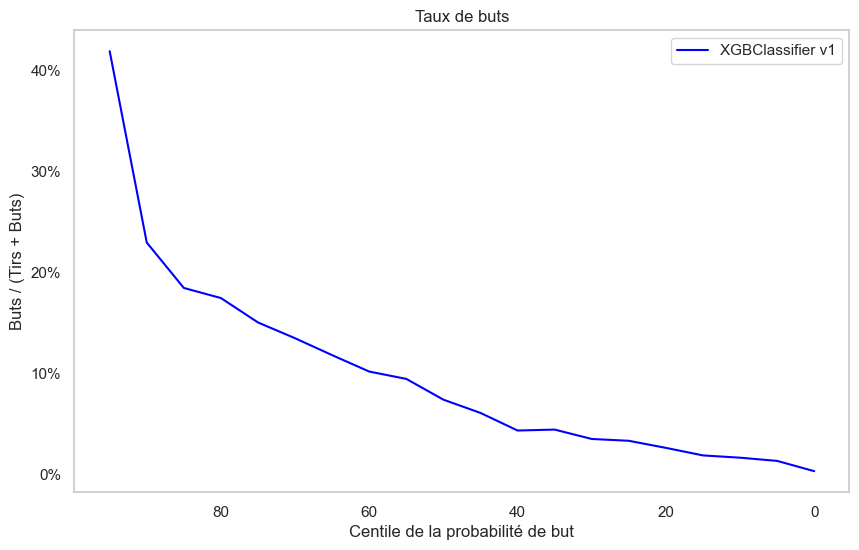

In [73]:
gr_df = results_v2.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

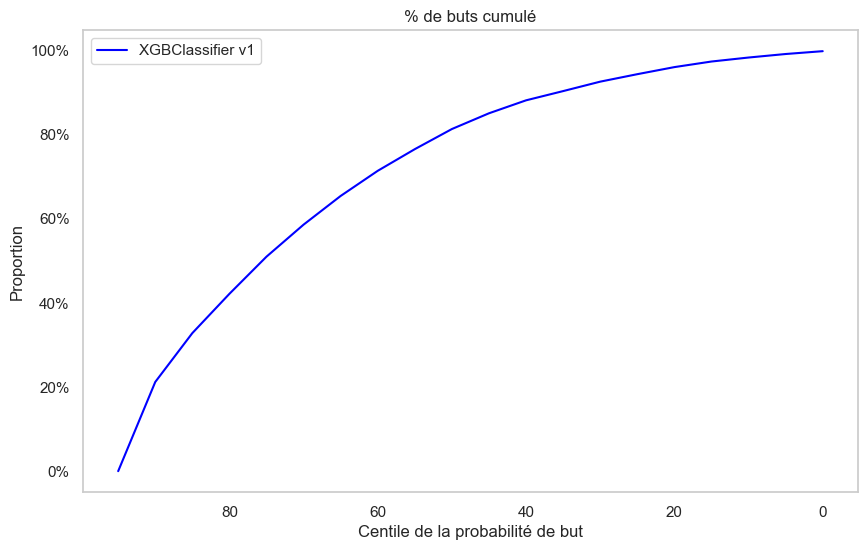

In [74]:
cg_df = results_v2.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

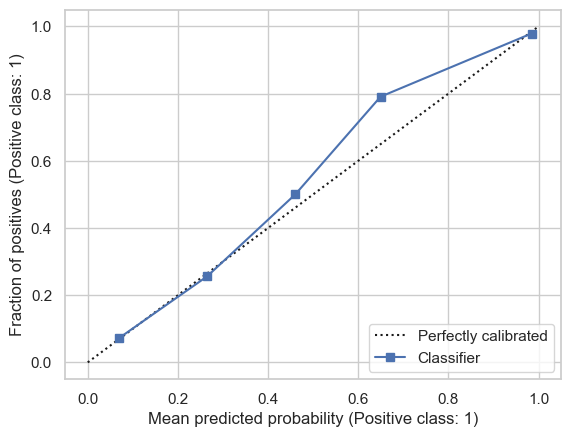

In [75]:
disp = CalibrationDisplay.from_predictions(y_val, results_v1['goal_proba'])
plt.show()